In [1]:
import pandas as pd
import os
import sqlite3
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Tools

In [16]:
def pid_count(df, *the_rest):
    def _cal(df):
        return len(df.drop_duplicates('pid'))
    print(*list(map(_cal, [df]+list(the_rest))), sep=', ')

In [95]:
def link(pid):
    return print(all_date.loc[all_date.pid==str(pid)].proj_url[:1].item())

In [109]:
def show_NaN(df):
    count = 0
    for i in df.columns.values.tolist():
        while df[i].isnull().values.any(): count+=1; print(i); break

# Data

In [5]:
conn_proj_urls = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'proj_urls.db')
conn_date_fund = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'date_fund.db')
conn_date_rew = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'date_rew.db')

proj_urls = pd.read_sql_query('SELECT * FROM proj_urls', conn_proj_urls)
date_fund = pd.read_sql_query('SELECT * FROM date_funding', conn_date_fund)
date_rew = pd.read_sql_query('SELECT * FROM date_reward', conn_date_rew)

In [111]:
conn_all_date = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'all_date.db')
all_date = pd.read_sql_query('SELECT * FROM all_date', conn_all_date)

In [49]:
conn_all_date_year = sqlite3.connect(directory + '/dataPrep/source/overall/' + 'all_date_year.db')
all_date_year = pd.read_sql_query('SELECT * FROM all_date_year', conn_all_date_year)

# Category

In [6]:
proj_urls[['category', 'subcategory']].drop_duplicates('subcategory').sort_values(
    by=['category', 'subcategory']).groupby('category').count().reset_index()

,category,subcategory
0,art,13
1,comics,5
2,crafts,14
3,dance,4
4,design,7
5,fashion,9
6,film & video,18
7,food,11
8,games,8
9,journalism,6


In [10]:
proj_urls[['category', 'subcategory']].drop_duplicates('subcategory').sort_values(
    by=['category', 'subcategory']).groupby('category').get_group('art')

,category,subcategory
100,art,Art
784,art,Ceramics
327,art,Conceptual Art
519,art,Digital Art
4,art,Illustration
566,art,Installations
149,art,Mixed Media
26,art,Painting
236,art,Performance Art
148,art,Public Art


# Hidden Projects

In [17]:
pid_count(date_fund[date_fund.proj_end_date == 'hidden'])

46


# Successful Projects

In [18]:
count_by_date = proj_urls[['pid', 'category', 'proj_start_date']].copy()

# extract year
count_by_date['proj_start_year'] = count_by_date['proj_start_date'].str.extract(
    r'(.*)-[0-1][0-9]-[0-3][0-9]', expand=False)

# extract month
count_by_date['proj_start_month'] = count_by_date['proj_start_date'].str.extract(r'-(.*)-', expand=False)

## by funding start year

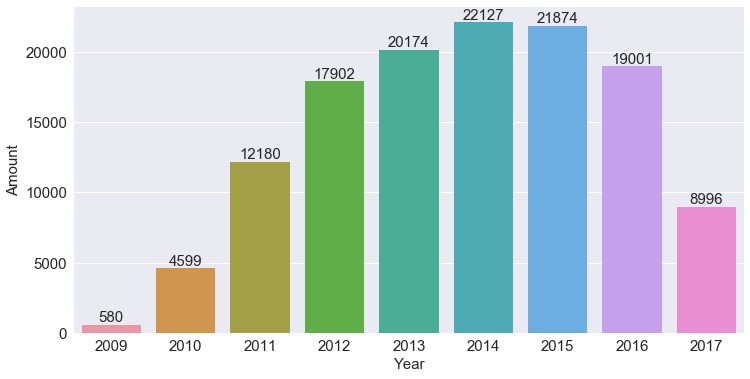

In [34]:
# plot
f, ax = plt.subplots(figsize=(12, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="proj_start_year", data=count_by_date)
ax.set_ylabel('Amount', fontsize=15)    
ax.set_xlabel('Year', fontsize=15)
amount = count_by_date.groupby(['proj_start_year'])['pid'].agg('count').values    
rects = ax.patches
labels = ["%d" % i for i in amount] # make some labels
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

## by category

### 2016

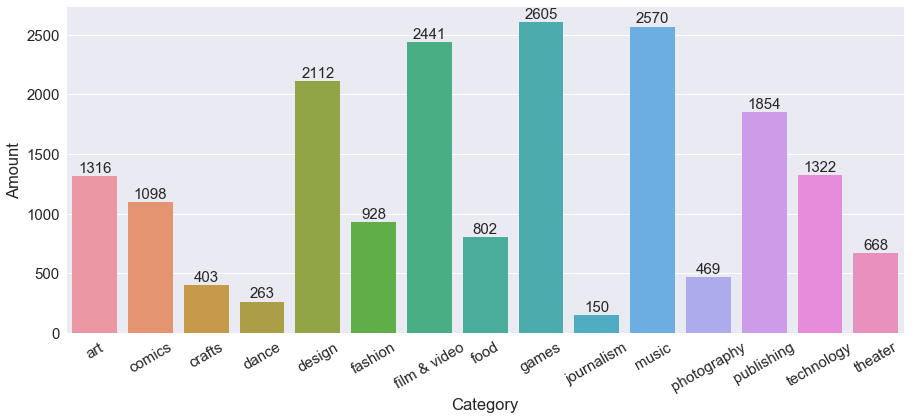

In [37]:
# plot
all_proj_2016 = count_by_date.loc[count_by_date['proj_start_year']=='2016'].sort_values('category')
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="category", data=all_proj_2016)
ax.set_ylabel('Amount')    
ax.set_xlabel('Category')
plt.xticks(rotation=30) 
amount = all_proj_2016.groupby(['category'])['pid'].agg('count').values    
rects = ax.patches
# make some labels
labels = ["%d" % i for i in amount]
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

### from 2014 to 2016

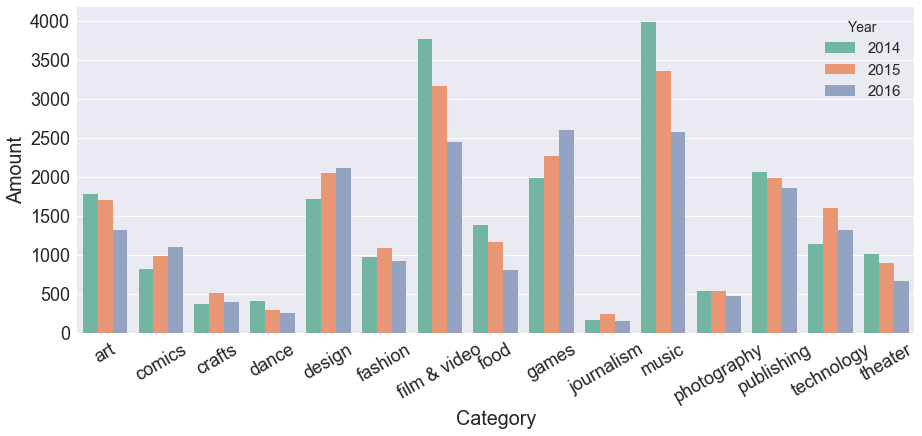

In [40]:
# plot
all_proj_1416 = count_by_date.loc[count_by_date['proj_start_year'].str.contains('2014|2015|2016')].sort_values('category')
all_proj_1416 = all_proj_1416.rename(columns = {'proj_start_year': 'Year'})
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="category", hue='Year', data=all_proj_1416, palette="Set2")
ax.set_ylabel('Amount')    
ax.set_xlabel('Category')
plt.xticks(rotation=30) 
rects = ax.patches

## By Estimated Delivery Year

#### since projects do not have delivery date before 2012...

https://www.kickstarter.com/blog/accountability-on-kickstarter
>As Kickstarter has grown, we've made changes to improve accountability and fulfillment. In August 2011 we began requiring creators to list an "Estimated Delivery Date" for all rewards. 

In [112]:
show_NaN(all_date)

rew_amount_required
rew_backer_count
rew_backer_limit
rew_delivery
rew_id


In [44]:
# Remove the record which is no delivery date
all_date = all_date[all_date['rew_delivery'].str.contains('None')==False]

In [45]:
# Convert date from string to datetime format
all_date['rew_delivery'] = all_date['rew_delivery'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))
all_date['proj_start_date'] = all_date['proj_start_date'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))
all_date['proj_end_date'] = all_date['proj_end_date'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))

In [46]:
rew_delivery_year = all_date[['pid', 'rew_delivery', 'proj_start_date', 
                              'proj_end_date', 'category', 'subcategory', 'proj_url']].copy()
rew_delivery_year['rew_delivery_year'] = rew_delivery_year['rew_delivery'].apply(
    lambda date: datetime.datetime.strftime(date, '%Y'))
rew_delivery_year = rew_delivery_year.drop_duplicates(subset=['pid','rew_delivery_year'])

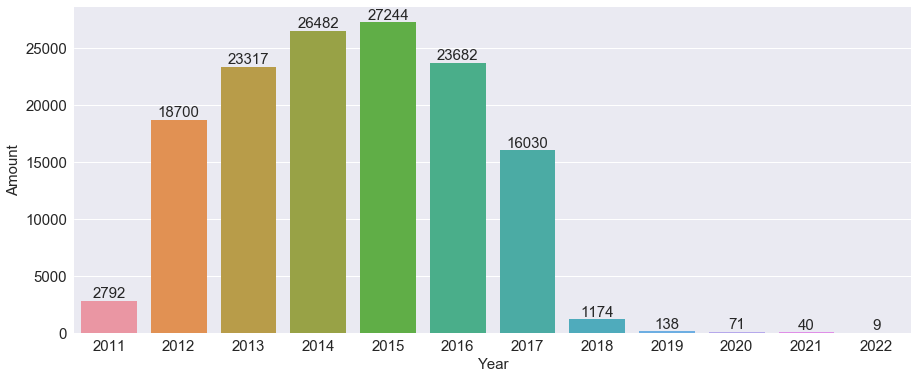

In [48]:
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="rew_delivery_year", data=rew_delivery_year)
ax.set_ylabel('Amount', fontsize=15)    
ax.set_xlabel('Year', fontsize=15)
amount = rew_delivery_year.groupby(['rew_delivery_year'])['pid'].agg('count').values    
rects = ax.patches
# make some labels
labels = ["%d" % i for i in amount]
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

# projects which deliver rewards within 2015-07 and 2016-06

In [52]:
all_date_year['rew_delivery'] = all_date_year['rew_delivery'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))
all_date_year['proj_start_date'] = all_date_year['proj_start_date'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))
all_date_year['proj_end_date'] = all_date_year['proj_end_date'].apply(
    lambda str_date: datetime.datetime.strptime(str_date, "%Y-%m-%d"))
all_date_year['proj_end_year'] = all_date_year['proj_end_date'].apply(
    lambda date: datetime.datetime.strftime(date, '%Y'))

#### the first project end date is 2011-09-08...

In [53]:
all_date_year['proj_end_date'].describe()

count                  213741
unique                   1021
top       2015-07-01 00:00:00
freq                     1266
first     2011-09-08 00:00:00
last      2016-06-30 00:00:00
Name: proj_end_date, dtype: object

In [54]:
pid_count(all_date_year)

26229


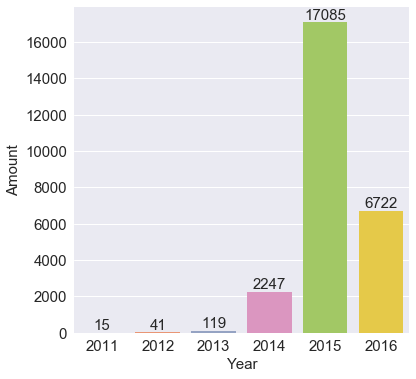

In [60]:
all_date_year_proj = all_date_year.drop_duplicates('pid').copy()
f, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.5)
ax = sns.countplot(x="proj_end_year", data=all_date_year_proj, palette="Set2")
ax.set_ylabel('Amount', fontsize=15)    
ax.set_xlabel('Year', fontsize=15)
amount = all_date_year_proj.groupby(['proj_end_year'])['pid'].agg('count').values    
rects = ax.patches
# make some labels
labels = ["%d" % i for i in amount]
for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

## Creation Period

In [75]:
first_deliver_date = all_date_year.sort_values('rew_delivery').drop_duplicates('pid').copy()

first_deliver_date['creation'] = first_deliver_date.rew_delivery - first_deliver_date.proj_end_date
first_deliver_date.creation.describe()

count                       26229
mean      81 days 06:29:34.676884
std      138 days 12:56:22.918915
min            -39 days +00:00:00
25%             -1 days +00:00:00
50%              32 days 00:00:00
75%             105 days 00:00:00
max            1537 days 00:00:00
Name: creation, dtype: object

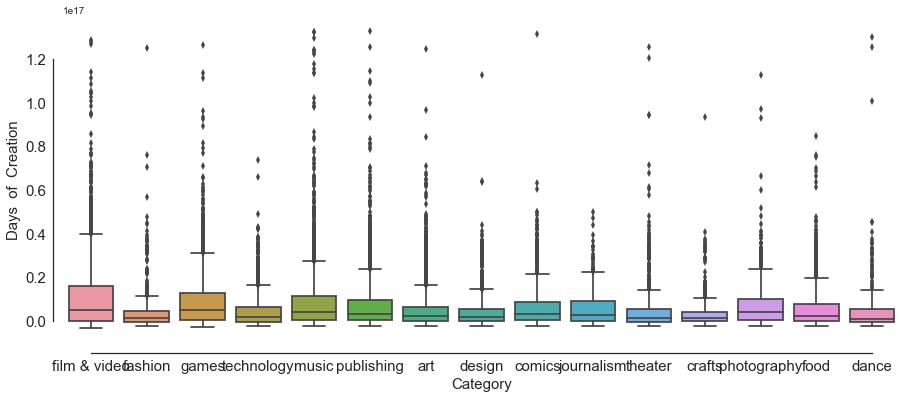

In [77]:
sns.set(style="ticks")
# Draw a nested boxplot to show bills by day and sex
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.5)
sns.boxplot(x='category', y='creation', data=first_deliver_date) # palette="PRGn"
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Days  of  Creation', fontsize=15)
sns.despine(offset=10, trim=True)

#### Exclude Outliers (values between Q1 - 1.5 IQR and Q3 + 1.5 IQR)

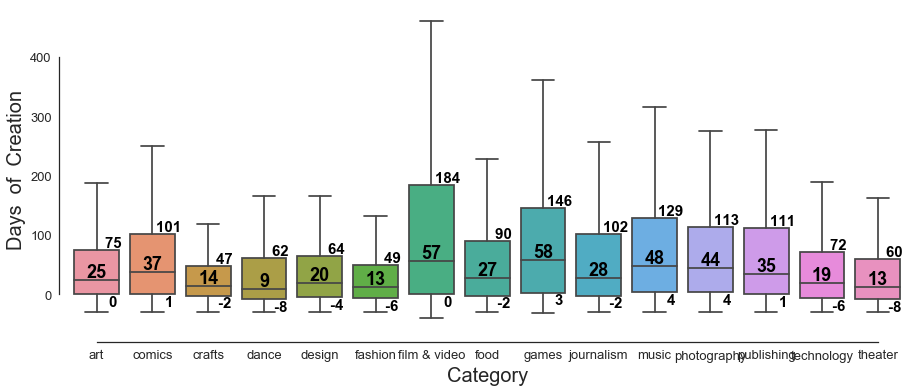

In [108]:
days = first_deliver_date.sort_values('category').copy()
days.creation = days.creation.apply(lambda td: (td / np.timedelta64(1, 'D')).astype(int))

sns.set(style="ticks")
# Draw a nested boxplot to show bills by day and sex
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.3)
sns.boxplot(x='category', y='creation', data=days, showfliers=False)
ax.set_xlabel('Category', fontsize=20)
ax.set_ylabel('Days  of  Creation', fontsize=20)
sns.despine(offset=10, trim=True)


Q1 = days.groupby(['category'])['creation'].quantile(.25).values.astype(int)
Q2 = days.groupby(['category'])['creation'].quantile(.5).values.astype(int)
Q3 = days.groupby(['category'])['creation'].quantile(.75).values.astype(int)
Q1_labels = ['        ' + str(np.round(s, 2)) for s in Q1]
Q2_labels = [str(np.round(s, 2)) for s in Q2]
Q3_labels = ['        ' + str(np.round(s, 2)) for s in Q3]

pos = range(len(Q2))
for tick,label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick] , Q1[tick] - 20, Q1_labels[tick], fontsize=15, 
            horizontalalignment='center', color='k', weight='semibold')
    ax.text(pos[tick], Q2[tick] + 5, Q2_labels[tick], fontsize=18, 
            horizontalalignment='center', color='k', weight='semibold')
    ax.text(pos[tick] , Q3[tick] + 5, Q3_labels[tick], fontsize=15, 
            horizontalalignment='center', color='k', weight='semibold')

# it could be a problem if we use the first EDD as the turing point...
For example: https://www.kickstarter.com/projects/1582272995/the-strange-1st-anniversary-playing-card-set
>Pledge US$ 1 or more

>Thanks for the pledge! We will keep you updated on our current progress!

In [79]:
first_deliver_date.groupby(['category'])['creation'].min()

category
art            -30 days
comics         -30 days
crafts         -30 days
dance          -30 days
design         -30 days
fashion        -30 days
film & video   -39 days
food           -30 days
games          -32 days
journalism     -30 days
music          -30 days
photography    -29 days
publishing     -30 days
technology     -30 days
theater        -30 days
Name: creation, dtype: timedelta64[ns]

In [93]:
deliver_before_end = first_deliver_date[first_deliver_date.creation < datetime.timedelta(days=0)]
len(deliver_before_end)

6653

# how about the last EDD

In [115]:
last_deliver_date = all_date_year.sort_values('rew_delivery', ascending=False).drop_duplicates('pid').copy()

last_deliver_date['creation'] = last_deliver_date.rew_delivery - last_deliver_date.proj_end_date
last_deliver_date.creation.describe()

count                       26229
mean     120 days 16:55:10.534141
std      140 days 16:33:38.674031
min            -30 days +00:00:00
25%              31 days 00:00:00
50%              80 days 00:00:00
75%             163 days 00:00:00
max            1537 days 00:00:00
Name: creation, dtype: object

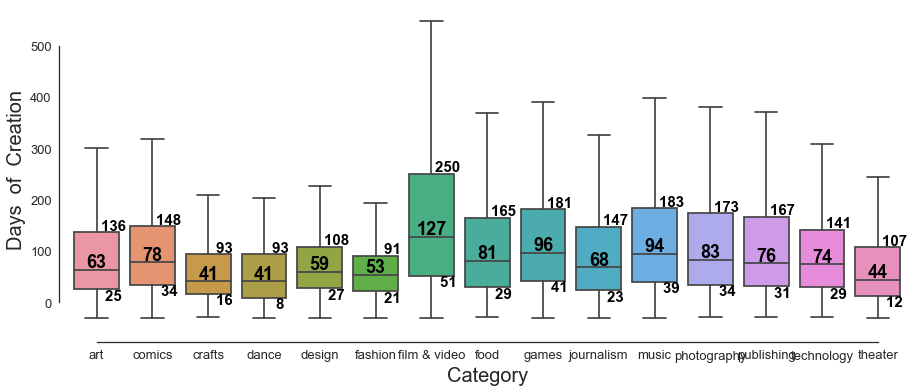

In [116]:
days = last_deliver_date.sort_values('category').copy()
days.creation = days.creation.apply(lambda td: (td / np.timedelta64(1, 'D')).astype(int))

sns.set(style="ticks")
# Draw a nested boxplot to show bills by day and sex
f, ax = plt.subplots(figsize=(15, 6))
sns.set(font_scale=1.3)
sns.boxplot(x='category', y='creation', data=days, showfliers=False)
ax.set_xlabel('Category', fontsize=20)
ax.set_ylabel('Days  of  Creation', fontsize=20)
sns.despine(offset=10, trim=True)


Q1 = days.groupby(['category'])['creation'].quantile(.25).values.astype(int)
Q2 = days.groupby(['category'])['creation'].quantile(.5).values.astype(int)
Q3 = days.groupby(['category'])['creation'].quantile(.75).values.astype(int)
Q1_labels = ['        ' + str(np.round(s, 2)) for s in Q1]
Q2_labels = [str(np.round(s, 2)) for s in Q2]
Q3_labels = ['        ' + str(np.round(s, 2)) for s in Q3]

pos = range(len(Q2))
for tick,label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick] , Q1[tick] - 20, Q1_labels[tick], fontsize=15, 
            horizontalalignment='center', color='k', weight='semibold')
    ax.text(pos[tick], Q2[tick] + 5, Q2_labels[tick], fontsize=18, 
            horizontalalignment='center', color='k', weight='semibold')
    ax.text(pos[tick] , Q3[tick] + 5, Q3_labels[tick], fontsize=15, 
            horizontalalignment='center', color='k', weight='semibold')

In [117]:
last_deliver_date.groupby(['category'])['creation'].min()

category
art            -30 days
comics         -30 days
crafts         -29 days
dance          -30 days
design         -30 days
fashion        -30 days
film & video   -30 days
food           -28 days
games          -30 days
journalism     -30 days
music          -30 days
photography    -29 days
publishing     -29 days
technology     -29 days
theater        -30 days
Name: creation, dtype: timedelta64[ns]

In [118]:
deliver_before_end = last_deliver_date[last_deliver_date.creation < datetime.timedelta(days=0)]
len(deliver_before_end)

2177